# Analysis and Visualization code for mouse PDAC data
## 20241219

In [29]:
import pandas as pd
import numpy as np
import anndata as ad
import scanpy as sc
from scipy.sparse import csr_matrix
from scipy.stats import pearsonr,spearmanr
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import matplotlib as mat
import os
import sys
from scipy import stats
import warnings
import cell2location
from sklearn.preprocessing import MinMaxScaler,StandardScaler
warnings.filterwarnings("ignore")

plt.rcParams['font.size'] = 10
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [30]:
# set the working directory
os.chdir("/aaa/zihanwu/yyyli2/project1_spatial_deconv/code_data_availability/Spatial_DC_V1")
dataset_dir = "datasets/mouse_PDAC/"
scaler = MinMaxScaler(feature_range=(0, 1))

# Visualization of original reference data and spatial proteomics data.

         Falling back to preprocessing with `sc.pp.pca` and default params.


2024-12-19 16:29:27.543410: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-19 16:29:27.596538: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-19 16:29:28.322150: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


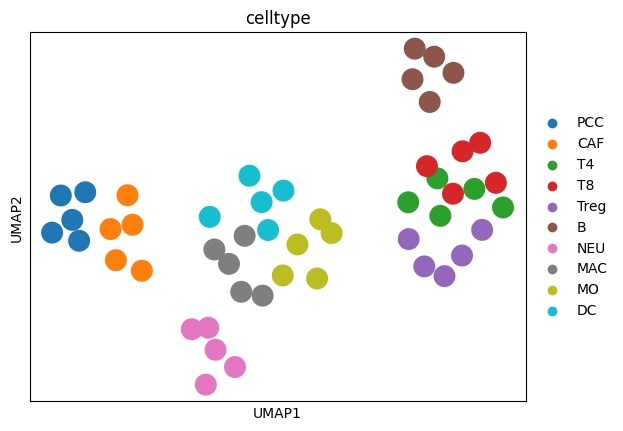

In [2]:
# Visualization of reference data
sc_adata = sc.read_h5ad(f"{dataset_dir}/original_reference_proteomics.h5ad")

ct_order = ['PCC', 'CAF', 'T4', 'T8', 'Treg', 'B', 
       'NEU', 'MAC', 'MO', 'DC']
sc_adata.obs["celltype"] = sc_adata.obs["celltype"].astype("category")
sc_adata.obs["celltype"] = sc_adata.obs["celltype"].cat.set_categories(ct_order,ordered=False)

# vis with UMAP
sc.pp.normalize_total(sc_adata)
sc.pp.log1p(sc_adata)

sc.pp.neighbors(sc_adata, n_pcs=20, n_neighbors=10)
sc.tl.umap(sc_adata)

sc.pl.umap(sc_adata, color=["celltype"], size=1000)


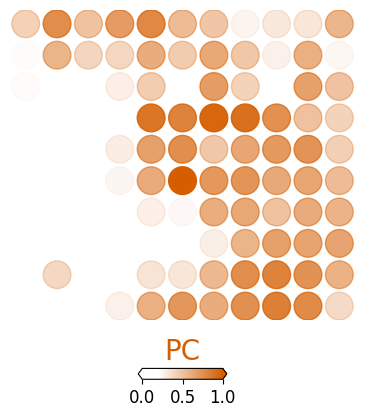

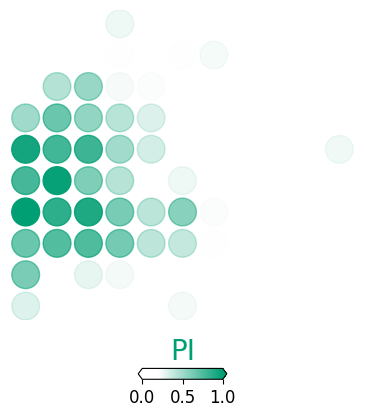

In [23]:
# Visualization of ground truth distribution for PC and PI
sp_adata = sc.read_h5ad(f"{dataset_dir}/original_spatial_proteomics.h5ad")
gd_df = pd.read_csv(f"{dataset_dir}/mIHC_intensity.csv",index_col=0,sep="\t")
sp_adata.obs = gd_df

# show the distribution of PC and PI
PC_plt = cell2location.plt.plot_spatial(sp_adata,show_img=False,labels=["PC"],color=["PC"],circle_diameter=20.0,reorder_cmap=[1],max_color_quantile=1)
PI_plt = cell2location.plt.plot_spatial(sp_adata,show_img=False,labels=["PI"],color=["PI"],circle_diameter=20.0,reorder_cmap=[3],max_color_quantile=1)

# Applications related to predicted cell-type composition

## Benchmarking analysis of predicted cell-type composition

       Method CellType PCC_metrics SPCC_metrics
0  Spatial-DC       PC       0.664        0.696
1  Spatial-DC       PI       0.576        0.530


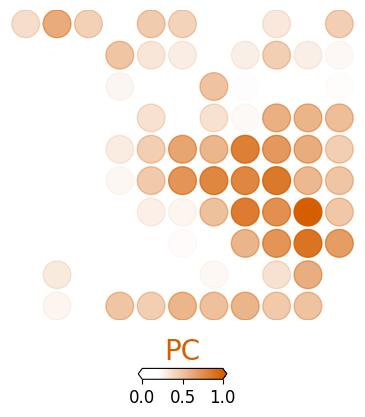

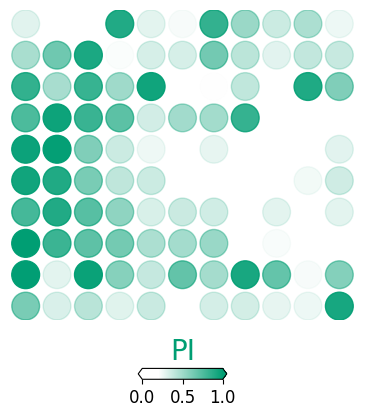

In [127]:
# Visualization and evaluation of between predictions and ground truth
sp_adata = sc.read_h5ad(f"{dataset_dir}/original_spatial_proteomics.h5ad")
pred_df = pd.read_csv(f"{dataset_dir}/Spatial_DC_pred.csv",index_col=0,sep=",")
sp_adata.obs = pred_df

ct_orders = ['PC','PI']    
pred_df["PI"] = pred_df[['T4', 'T8', 'Treg', 'B', 'NEU', 'MAC', 'MO', 'DC']].sum(axis=1).values

results = []
for ct in ct_orders:
    pcc_corr = pearsonr(gd_df[ct], pred_df[ct])[0]
    spcc_corr = spearmanr(gd_df[ct], pred_df[ct])[0]
    results.append({
    'Method': 'Spatial-DC',
    'CellType': ct,
    'PCC_metrics': '%.3f' % pcc_corr,
    'SPCC_metrics': '%.3f' % spcc_corr
})

sp_adata.obs[["PC","PI"]]= scaler.fit_transform(pred_df[["PC","PI"]]) # scale for each cell type

# show the distribution of PC and PI
PC_plt = cell2location.plt.plot_spatial(sp_adata,show_img=False,labels=["PC"],color=["PC"],circle_diameter=20.0,reorder_cmap=[1],max_color_quantile=1)
PI_plt = cell2location.plt.plot_spatial(sp_adata,show_img=False,labels=["PI"],color=["PI"],circle_diameter=20.0,reorder_cmap=[3],max_color_quantile=1)
print(pd.DataFrame(results))

## Co-occurrence analysis with spatial correlated and cell-type significant proteins

# Visualization of the Pearson correlation of cell type specific marker proteins
```R

# Run in R environment
{
    rm(list=ls())
    setwd("")
    obj_list = readRDS(file = "01_data/MousePDAC_reference_ct10.RDS")        

    # keep intersected pid from ct 6
    dep_df = obj_list$aov_ct10_df %>% filter(log2FC > log2(1.2)) %>% filter(fdr < 0.05) # 1334
    pred_df = obj_list$pred_corr %>% filter(corr > 0.7) # 233
    pred_df$gene = obj_list$anno_df[pred_df$pids,"gene"]

    ct_order = c('PCC', 'CAF', 'DC', 'NEU', 'T4', 'B')        
    dep_df$ID = paste0(dep_df$celltype, "_", dep_df$pid)
    pred_df$ID = paste0(pred_df$celltype, "_", pred_df$pids)

    intersected_ID = intersect(dep_df$ID, pred_df$ID) # 51        
    pred_df = pred_df[which(pred_df$ID %in% intersected_ID),]
    pred_df$celltype = factor(pred_df$celltype, levels=c("PCC","CAF","DC"))
    pred_df = pred_df %>% arrange(celltype, desc(corr)) # 51
                            
    # plot pred corr
    pred_plot_data = obj_list$pred_corr_spread
    pred_plot_data = pred_plot_data[pred_df$pids,ct_order]
    row.names(pred_plot_data) = pred_df$gene

    # vis of pred_corr as heat map
    range_all <- range(c(-1, 1))    
    my_palette <- colorRampPalette(c("navy", "grey","white","#ffb74d","red"))(n=100)
    breaks = seq(range_all[1], range_all[2], length.out = 101)
    pheatmap::pheatmap(pred_plot_data,scale="none", color=my_palette,breaks=breaks,cluster_cols=F,cluster_rows=F,silence=F,show_rownames=T,fontsize=10)
    
}
```

<p><img width="300",height="300", src="./co_occurrence_analysis/pred_marker_panel.jpg"/> </p>



```R
# Visualization of the corresponding proteins on reference data
# Run in R environment
{
    ref_plot_data = obj_list$data_mean_df
    ref_plot_data = ref_plot_data[pred_df$pids,]

    scale_ref_plot_data = t(apply(ref_plot_data, 1, scale)) %>% as.data.frame()
    names(scale_ref_plot_data) =  names(ref_plot_data)    
    head(scale_ref_plot_data)
    row.names(scale_ref_plot_data) = pred_df$gene
    
    # my_palette = colorRampPalette(c("navy", "white","firebrick3"))(n=100)
    range_all = range(c(-2, 2))            
    breaks = seq(range_all[1], range_all[2], length.out = 101)

    pheatmap::pheatmap(scale_ref_plot_data,scale="none",cluster_rows = F,cluster_cols = F,show_colnames=T,fontsize=10,
                show_rownames = T, silent = F,color = my_palette,breaks = breaks,                
    )
    
}
```

<p><img width="400",height="400", src="./co_occurrence_analysis/reference_marker_panel.jpg"/> </p>


PC_ct_perc vs Agr2_O88312: 0.8638
PC_ct_perc vs Clu_Q06890: 0.7871


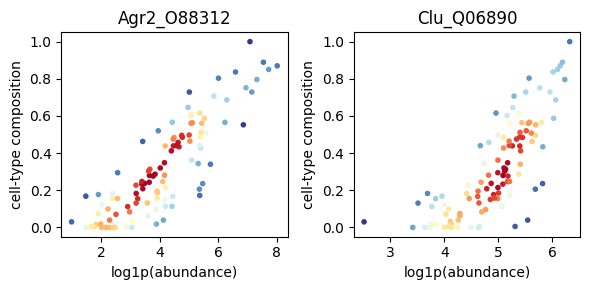

In [60]:
# Comparision of PC-related proteins [Agr2 and Clu] between cell-type composition and original spatial proteomics data
sp_adata = sc.read_h5ad(f"{dataset_dir}/original_spatial_proteomics.h5ad")

df = sp_adata.var
df['pids'] = df.apply(lambda row: str(row['gene']) +"_"+ str(row['pid']), axis=1)
sp_adata.var.index = sp_adata.var["pids"]

sc.pp.normalize_total(sp_adata)
sc.pp.log1p(sp_adata)

selected_markers = ["Agr2_O88312","Clu_Q06890"]
scale_df = sp_adata.to_df()[selected_markers]

pred_df = pd.read_csv(f"{dataset_dir}/Spatial_DC_pred.csv",index_col=0,sep=",")
pred_df = pd.DataFrame(scaler.fit_transform(pred_df),index=pred_df.index,columns=pred_df.columns) # Scale for each cell type

# scatter plot
fig, axs = plt.subplots(1, 2, figsize=(6, 3))
for j, ct in enumerate(selected_markers):
    
    p = sp_adata.to_df()[ct].values
    g = pred_df["PC"].values
    print(f'PC_ct_perc vs {ct}: {"%.4f" % pearsonr(p,g)[0]}')

    values = np.vstack([g, p])
    kernel = stats.gaussian_kde(values)(values)
    axs[j].scatter(p, g, cmap="RdYlBu_r",c=kernel,marker='.')
    
    axs[j].set_ylabel("cell-type composition")
    axs[j].set_xlabel("log1p(abundance)")
    axs[j].set_title(f"{ct}")

plt.tight_layout()

<module 'matplotlib.pyplot' from '/data/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/matplotlib/pyplot.py'>

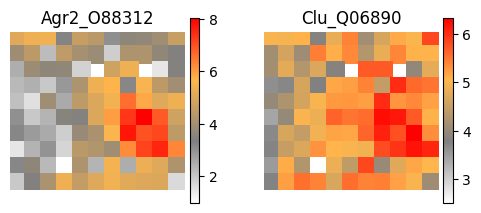

In [91]:
# spatial map of selected markers
import matplotlib.colors as mcolors
my_cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', ['white', 'grey','#ffb74d', 'red'])
spatial = pd.DataFrame(sp_adata.obsm['spatial'], index=sp_adata.obs_names,columns=["x","y"])

# plot spatial map of selected markers
fig, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
for i in range(2):
    selected_markers_order = selected_markers[i]
    pred_df_1 = scale_df[selected_markers_order].values
    sc_bar_1 = ax1[i].scatter(spatial['x'], -spatial['y'],s=190, edgecolors='none', facecolors='none',marker="s",
            c=pred_df_1,cmap=my_cmap)
    ax1[i].set_aspect('equal', 'box')
    ax1[i].set_xticks([])
    ax1[i].set_yticks([])

    ax1[i].set_title(selected_markers[i])
    ax1[i].axis('off')
    fig.colorbar(sc_bar_1, ax=ax1[i], orientation='vertical', pad=0.02, aspect=20, shrink=0.8)
plt

## Co-occurrence analysis with spatial correlated and cell-type significant proteins


```R
# Visualization of predicted proteins on reference data
# Run in R environment
{
    library(dplyr)
    rm(list=ls())
    setwd("./Spatial_DC_V1/datasets/mouse_PDAC")

    pred_df = read.csv("/Spatial_DC_pred.csv",header=T,row.names=1,sep="\t") %>% t() %>% as.data.frame()    
    pred_df_filter = pred_df[which(rowSums(pred_df) > 0),] %>% t() %>% as.data.frame()

    corr_df = cor(data_df_filter, method="pearson")

    range_all <- range(c(-1, 1))    
    my_palette <- colorRampPalette(c("navy", "white","firebrick3"))(n=100)
    breaks = seq(range_all[1], range_all[2], length.out = 101)

    p1=pheatmap::pheatmap(corr_df, color=my_palette, breaks=breaks)
    print(p1)

    order_df = corr_df[p1$tree_row$labels[p1$tree_row$order],p1$tree_col$labels[p1$tree_col$order]]
    write.csv(order_df,"co_localization_analysis_order.csv")
    
}
```

<p><img width="300",height="300" src="./co_localization_analysis/co_localization.jpg"/> </p>


# Applications related to reconstructed cell-type proteomic profiles

## Basic functional analysis for reconstructed proteomic profiles
Involving UMAP, known markers, GP-BP and MF analysis

         Falling back to preprocessing with `sc.pp.pca` and default params.


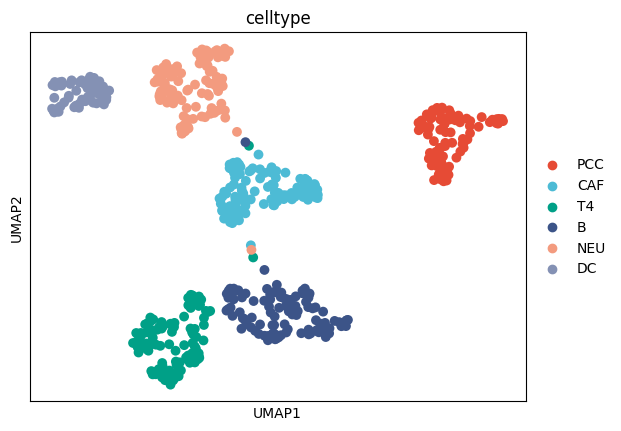

In [93]:
# visualization of spatially and cell-type resolved data from Spatial-DC
scp_adata = sc.read_h5ad(f"{dataset_dir}/Spatial_DC_reconstruct_norm.h5ad")

sc.pp.filter_cells(scp_adata, min_counts=10)
sc.pp.filter_genes(scp_adata, min_cells=3)

scp_adata = scp_adata[scp_adata.obs["cellperc"] > 0.01]

sc.pp.normalize_total(scp_adata)
sc.pp.log1p(scp_adata)

ct_order = ["PCC", "CAF", "T4", "B","NEU", "DC"]

scp_adata.obs["celltype"] = scp_adata.obs["celltype"].astype("category")
scp_adata.obs["celltype"] = scp_adata.obs["celltype"].cat.set_categories(ct_order,ordered=False)

sc.pp.neighbors(scp_adata, n_pcs=20, n_neighbors=10)
sc.tl.umap(scp_adata)

my_palette = ["#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF", "#8491B4FF","#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF"]
scp_adata.uns["celltype_colors"] = my_palette


sc.pl.umap(scp_adata, color=["celltype"], size=200)

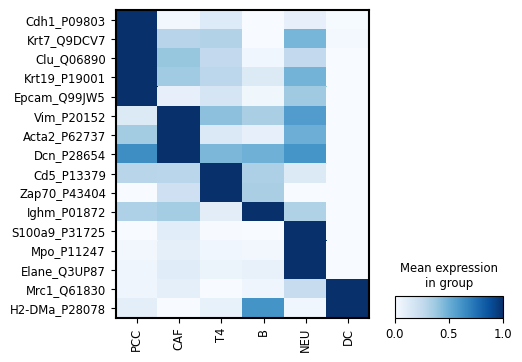

In [109]:
# Known marker analysis
scp_adata = sc.read_h5ad(f"{dataset_dir}/Spatial_DC_reconstruct_norm.h5ad")

sc.pp.filter_cells(scp_adata, min_counts=10)
sc.pp.filter_genes(scp_adata, min_cells=3)
scp_adata = scp_adata[scp_adata.obs["cellperc"] > 0.01]
ct_order = ["PCC", "CAF", "T4", "B","NEU", "DC"]
scp_adata.obs["celltype"] = scp_adata.obs["celltype"].astype("category")
scp_adata.obs["celltype"] = scp_adata.obs["celltype"].cat.set_categories(ct_order,ordered=False)

df = scp_adata.var
df['pids'] = df.apply(lambda row: str(row['gene']) +"_"+ str(row['pid']), axis=1)
scp_adata.var.index = scp_adata.var["pids"]
sc.pp.normalize_total(scp_adata)

markers_list=[    
    "Cdh1_P09803","Krt7_Q9DCV7","Clu_Q06890","Krt19_P19001","Epcam_Q99JW5",    
    "Vim_P20152", "Acta2_P62737","Dcn_P28654",
    "Cd5_P13379","Zap70_P43404",
    "Ighm_P01872",
    "S100a9_P31725","Mpo_P11247","Elane_Q3UP87",
    "Mrc1_Q61830","H2-DMa_P28078"

]

ax=sc.pl.matrixplot(scp_adata, markers_list,'celltype',return_fig=True,dendrogram=False,swap_axes="False",figsize=[5,4],cmap="Blues",standard_scale="var")
ax.edge_color="none"
ax.show()

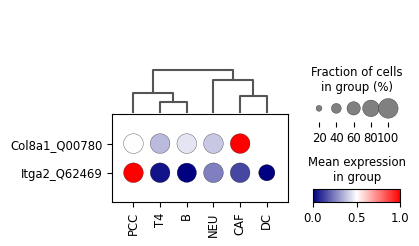

In [125]:
# Dot plot of selected L-Rs
colors = ['navy',"white", 'red']
my_cmap = mcolors.LinearSegmentedColormap.from_list('mycmap', colors)

LR_markers = ["Col8a1_Q00780","Itga2_Q62469"]

sc.pl.dotplot(scp_adata, LR_markers, groupby='celltype', dendrogram=True,standard_scale="var",swap_axes="True",cmap=my_cmap)

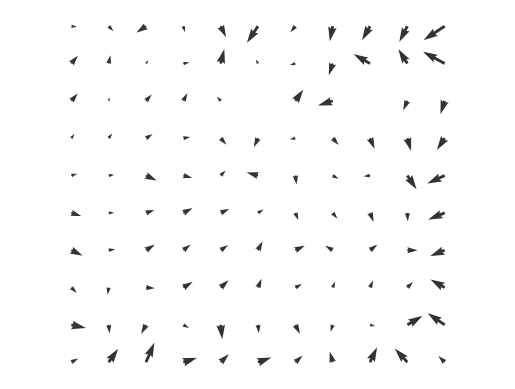

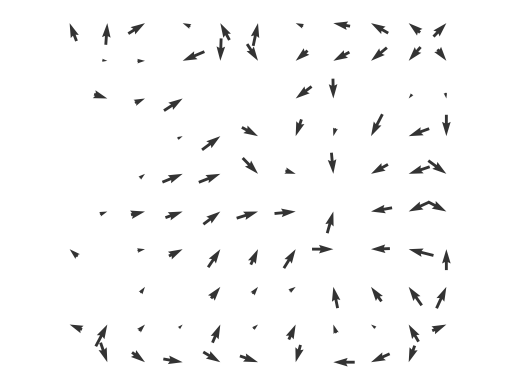

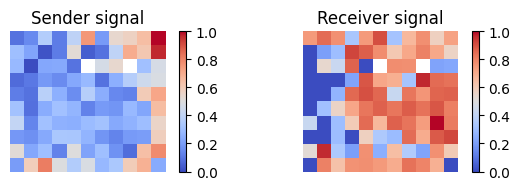

In [126]:
# Communication of CAF and PC via Col8a1 and Itga2
import commot as ct

scp_adata = sc.read_h5ad(f"{dataset_dir}/Spatial_DC_reconstruct_not_norm.h5ad") # using actual reconstructed data without normalization by predicted cell-type composition

# set zero of cellperc < 0.01
set_zero = scp_adata.obs["cellperc"] < 0.01
temp_arr = np.array(scp_adata.to_df())
temp_arr[set_zero,:]=0
scp_adata.X = temp_arr

# keep target cells, first CAF and then PC
ct_order = ["CAF"]
keep_index = scp_adata.var["gene"].isin(["Col8a1","Itga2"])
keep_ct = scp_adata.obs["celltype"].isin(ct_order)
target_adata = scp_adata[keep_ct,keep_index].copy()


df = target_adata.var
df['pids'] = df.apply(lambda row: str(row['gene']) +"_"+ str(row['pid']), axis=1)
target_adata.var.index = target_adata.var["gene"]
temp_index = [f"spot_{i}" for i in range(target_adata.shape[0])]
target_adata.obs.index = temp_index

temp_df = target_adata.to_df()

ct_order = ["PCC"]
keep_index = scp_adata.var["gene"].isin(["Itga2"])
keep_ct = scp_adata.obs["celltype"].isin(ct_order)
temp_df["Itga2"]  = scp_adata[keep_ct,keep_index].to_df().values

target_adata.X = np.array(temp_df)

# prepare adata
target_adata.obs[["Y"]] = -target_adata.obs[["Y"]]
target_adata.obsm["spatial"] = np.array(target_adata.obs[["X","Y"]])
sc.pp.log1p(target_adata)

target_ppi_df = pd.DataFrame({0:'Col8a1',1:'Itga2',2:'sig_ppi',3:'Secreted Signaling'},index=[0,1,2,3])
ct.tl.spatial_communication(target_adata,
    database_name='selected_db', df_ligrec=target_ppi_df, dis_thr=500, heteromeric=True, pathway_sum=True) 

ct.tl.communication_direction(target_adata, database_name='selected_db', pathway_name='sig_ppi', k=5)

ct.pl.plot_cell_communication(target_adata, database_name='selected_db', pathway_name='sig_ppi',normalize_v=True,normalize_v_quantile=0.995,summary="sender",
grid_density=0.4,scale=1.5,ndsize=0,grid_thresh=10,grid_scale=10,filename="sender.pdf",plot_method="cell")

ct.pl.plot_cell_communication(target_adata, database_name='selected_db', pathway_name='sig_ppi',normalize_v=True,normalize_v_quantile=0.995,clustering=None,summary="receiver",
grid_density=0.4,scale=1.5,ndsize=0,grid_thresh=10,grid_scale=10,filename="receiver.pdf",plot_method="cell")



adata = target_adata.copy()
pts = adata.obsm['spatial']

adata.obsm['commot-selected_db-sum-sender'][['s-Col8a1-Itga2']]= scaler.fit_transform(adata.obsm['commot-selected_db-sum-sender'][['s-Col8a1-Itga2']])  
adata.obsm['commot-selected_db-sum-receiver'][['r-Col8a1-Itga2']]= scaler.fit_transform(adata.obsm['commot-selected_db-sum-receiver'][['r-Col8a1-Itga2']])  

s = adata.obsm['commot-selected_db-sum-sender']['s-Col8a1-Itga2']
r = adata.obsm['commot-selected_db-sum-receiver']['r-Col8a1-Itga2']


# plot
fig, ax1 = plt.subplots(nrows=1, ncols=2, figsize=(6, 2))

sc1 = ax1[0].scatter(pts[:,0], pts[:,1],s=105, edgecolors='none', facecolors='none',marker="s",
        c=s,cmap='coolwarm')
ax1[0].set_aspect('equal', 'box')
ax1[0].set_xticks([])
ax1[0].set_yticks([])

ax1[0].set_title("Sender signal")
ax1[0].axis('off')

sc2 = ax1[1].scatter(pts[:,0], pts[:,1],s=105, edgecolors='none', facecolors='none',marker="s",
        c=r,cmap='coolwarm')
ax1[1].set_aspect('equal', 'box')
ax1[1].set_xticks([])
ax1[1].set_yticks([])

ax1[1].set_title("Receiver signal")
ax1[1].axis('off')

fig.colorbar(sc1, ax=ax1[0])
fig.colorbar(sc2, ax=ax1[1])
plt.tight_layout()
plt.show()

# Survival analysis of pancreatic patients from the LinkedOmicsKB

In [ ]:
```R
# Run in R environment
library(dplyr)
library(ggplot2)
library(survival)
library(survminer)
library(org.Hs.eg.db)

# 1. Preprocess proteomic data from database.
{    

    setwd("./Spatial_DC_V1/datasets/mouse_PDAC")
    data_df = read.delim("PDAC_clinical_data/PDAC_proteomics_gene_abundance_log2_reference_intensity_normalized_Tumor.txt", check.names=FALSE)
    data_df$idx = gsub(data_df$idx,pattern="\\..*",replacement="")

    tran_df = clusterProfiler::bitr(data_df$idx, fromType = "ENSEMBL", toType = "SYMBOL", OrgDb = org.Hs.eg.db)
    data_df = data_df %>% merge(tran_df, by.x="idx",by.y="ENSEMBL", all.x=F,all.y=F)    

    meta_df = read.delim("PDAC_clinical_data/PDAC_survival.txt", check.names=FALSE) %>% dplyr::select(case_id,OS_days,OS_event)
    meta_df = na.omit(meta_df)

    filter_df = data_df[,c("SYMBOL",meta_df$case_id)]
    head(filter_df)

    write.csv(filter_df,file="PDAC_clinical_data/PDAC_protein_filter_97.csv")
    write.csv(meta_df,file="PDAC_clinical_data/PDAC_survival_filter_97.csv")

}

# retain COL8A1 and ITGA2
{
    data_df = read.delim("PDAC_clinical_data/PDAC_protein_filter_97.csv", sep=",",row.names=1, check.names=FALSE)
    data_df = data_df %>% dplyr::filter(SYMBOL %in% c("COL8A1","ITGA2")) %>% na.omit()    
    row.names(data_df) = data_df$SYMBOL
    
    meta_df = read.delim("PDAC_clinical_data/PDAC_survival_filter_97.csv", sep=",",row.names=1, check.names=FALSE)
    data_df = na.omit(data_df[,meta_df$case_id]) 
    data_df = data_df %>% t() %>% as.data.frame()

    data_df = data_df %>% arrange(desc(COL8A1))
    data_df$rank1 = 1:dim(data_df)[1]
    head(data_df)

    data_df = data_df %>% arrange(desc(ITGA2))
    data_df$rank2 = 1:dim(data_df)[1]

    data_df$abundance = (data_df$rank1 + data_df$rank2)/2
    data_df$case_id = row.names(data_df)
    
    # merge
    cut_off = as.numeric(quantile(data_df$abundance,prob=0.5))    
    # high mean more abundance
    data_df$Group = "high"
    data_df[which(data_df$abundance >= cut_off), "Group"] = "low"
    
    # protein-1
    cut_off = as.numeric(quantile(data_df$COL8A1,prob=0.5))    
    # high mean more abundance
    data_df$Group_1 = "high"
    data_df[which(data_df$COL8A1 <= cut_off), "Group_1"] = "low"

    # protein-2
    cut_off = as.numeric(quantile(data_df$ITGA2,prob=0.5))    
    # high mean more abundance
    data_df$Group_2 = "high"
    data_df[which(data_df$ITGA2 <= cut_off), "Group_2"] = "low"


    plot_df = merge(data_df, meta_df, by="case_id",all=F)
    plot_df$OS_Years = plot_df$OS_days / 365

    filter_plot_df = plot_df %>% filter(Group_1 == Group_2)    
}

```R
# Run in R environment
# Plot survival curves for two groups
{            
    fit <- survfit(Surv(OS_Years, OS_event) ~ Group_1, data = filter_plot_df)
    p1=ggsurvplot(fit,pval = TRUE,
            conf.int = TRUE,            
            ggtheme = theme_bw(),
            palette = c("#E7B800", "#2E9FDF")
            )
    print(p1)    
}
```

<p><img width="600",height="300" src="./survival_analysis/survival_time.jpg"/> </p>
